In [1]:
import neuraltda.topology2 as tp2
import pandas as pd
from joblib import Parallel, delayed
import neuraltda.simpComp as sc
import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import datetime
import pickle
import glob
import os
from ephys import core, events, clust
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import h5py as h5
%matplotlib inline
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Set the parameters for the histograms and bin the spikes

In [ ]:
# Rebin with 5ms, no overlap, start+2500ms to end+300ms, correct trials
block_path = '/home/brad/emily/P01S15/'
winsize = 5.0
dtover = 0.0
segment = [2500, 300]

cluster_group = ['Good', 'MUA']
widenarrow_threshold = 0.000230 # sw threshold in seconds

In [2]:
spikes = core.load_spikes(block_path)
trials = events.load_trials(block_path)
fs = core.load_fs(block_path)

# Get wide/narrow clusters
clusters = core.load_clusters(block_path)
clusters_list = clusters[clusters.quality.isin(cluster_group)]['cluster'].unique()
(wide, narrow) = clust.get_wide_narrow(block_path, clusters_list, widenarrow_threshold)

# Get Correct/Incorrect Trials
correctTrials = trials[trials['correct']==True]
incorrectTrials = trials[trials['correct']==False]
passiveTrials = trials[-(trials['correct'].isin([True, False]))]

# Bin Correct Trials
bfdict = tp2.do_dag_bin_lazy(block_path, spikes, correctTrials, clusters, fs, winsize,
                                    segment, cluster_group=['Good', 'MUA'],
                                    dt_overlap=dtover, comment='SD-emily-reanalysis-correct')
bdf_correct = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
print('BDF: {}'.format(bdf_correct))

# Bin Incorrect Trials
bfdict = tp2.do_dag_bin_lazy(block_path, spikes, incorrectTrials, clusters, fs, winsize,
                                    segment, cluster_group=['Good', 'MUA'],
                                    dt_overlap=dtover, comment='SD-emily-reanalysis-incorrect')
bdf_incorrect = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
print('BDF: {}'.format(bdf_incorrect))

# Bin Passive Trials
bfdict = tp2.do_dag_bin_lazy(block_path, spikes, passiveTrials, clusters, fs, winsize,
                                    segment, cluster_group=['Good', 'MUA'],
                                    dt_overlap=dtover, comment='SD-emily-reanalysis-passive')
bdf_passive = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
print('BDF: {}'.format(bdf_incorrect))

BDF: /home/brad/emily/P01S15/binned_data/win-5.0_dtovr-0.0_seg-2500-300-SD-emily-reanalysis-correct/20170706T221954Z-5.0-0.0.binned
BDF: /home/brad/emily/P01S15/binned_data/win-5.0_dtovr-0.0_seg-2500-300-SD-emily-reanalysis-incorrect/20170706T222000Z-5.0-0.0.binned
BDF: /home/brad/emily/P01S15/binned_data/win-5.0_dtovr-0.0_seg-2500-300-SD-emily-reanalysis-incorrect/20170706T222000Z-5.0-0.0.binned


/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:224: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
--- Logging error ---
Traceback (most recent call last):
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/logging/__init__.py", line 994, in emit
    stream.write(msg)
AttributeError: 'int' object has no attribute 'write'
Call stack:
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher

- - - 
# Setup contexts

In [3]:
# contexts:
context_stimuli = {
    'A_hi': 'T40S40D3',
    'A_lo': 'T3S3D40',
    'AS_hi': 'T40S40D-1',
    'AS_lo': 'T3S3D-1',
    'ASX_hi': 'T40S40D-1',
    'ASX_lo': 'T3S3D-1',
    'AX_hi': 'T40S40D3',
    'AX_lo': 'T3S3D40',
    'P_hi': 'T40S40D3',
    'P_lo': 'T3S3D40'
}
context_bdf = {
    'A_hi': bdf_correct,
    'A_lo': bdf_correct,
    'AS_hi': bdf_correct,
    'AS_lo': bdf_correct,
    'ASX_hi': bdf_incorrect,
    'ASX_lo': bdf_incorrect,
    'AX_hi': bdf_incorrect,
    'AX_lo': bdf_incorrect,
    'P_hi': bdf_passive,
    'P_lo': bdf_passive
}
contexts = [
    'A_hi',
    'A_lo',
    'AS_hi',
    'AS_lo',
    'AX_hi',
    'AX_lo',
    'ASX_hi',
    'ASX_lo',
    'P_hi',
    'P_lo'
]

## Compute Average PSTHs

In [4]:
# compute average psths
avg_psths = {}
for context in contexts:
    with h5.File(context_bdf[context], 'r') as binned_data:
        stim = context_stimuli[context]
        fulldata = np.array(binned_data[stim]['pop_tens'])
        avg_psth = np.mean(fulldata, axis=2)
        avg_psths[str(context)] = avg_psth
        binned_clusters = np.array(binned_data[stim]['clusters'])

##  Mean-squared-error functions

In [5]:
# Compute MSEs:
from scipy import signal

def mse(psth_a, psth_b, psth_c, psth_d):
    la = psth_a.shape
    lb = psth_b.shape
    lc = psth_c.shape
    ld = psth_d.shape
    
    new_a = np.zeros((la[0], max(la[1], lb[1])))
    new_b = np.zeros((lb[0], max(la[1], lb[1])))
    new_a[:la[0], :la[1]] = psth_a
    new_b[:lb[0], :lb[1]] = psth_b
    
    new_c = np.zeros((lc[0], max(lc[1], ld[1])))
    new_d = np.zeros((ld[0], max(lc[1], ld[1])))
    new_c[:lc[0], :lc[1]] = psth_c
    new_d[:ld[0], :ld[1]] = psth_d
    
    mse_ab = np.sum(np.square(psth_a - psth_b), axis=1) /  (psth_a.shape[1])
    mse_cd = np.sum(np.square(psth_c - psth_d), axis=1) /  (psth_c.shape[1])
    return mse_ab + mse_cd

def mse_vec(psth_a, psth_b, psth_c, psth_d):
    
    la = psth_a.shape
    lb = psth_b.shape
    lc = psth_c.shape
    ld = psth_d.shape
    new_a = np.zeros((la[0], max(la[1], lb[1])))
    new_b = np.zeros((lb[0], max(la[1], lb[1])))
    new_a[:la[0], :la[1]] = psth_a
    new_b[:lb[0], :lb[1]] = psth_b
    
    new_c = np.zeros((lc[0], max(lc[1], ld[1])))
    new_d = np.zeros((ld[0], max(lc[1], ld[1])))
    new_c[:lc[0], :lc[1]] = psth_c
    new_d[:ld[0], :ld[1]] = psth_d
    
    mse_ab = np.square(new_a - new_b)
    mse_cd = np.square(new_c - new_d)
    return mse_ab + mse_cd

def exp_filt(vec, tau):
    M=51
    win = signal.exponential(M, 0, tau, False)
    return np.convolve(vec, win, mode='same')
    

## Compute Response Biases

In [6]:
MSE_targ = mse(avg_psths['A_hi'], avg_psths['AS_hi'], avg_psths['A_lo'], avg_psths['AS_lo'])
MSE_dist = mse(avg_psths['A_hi'], avg_psths['AS_lo'], avg_psths['A_lo'], avg_psths['AS_hi'])
MSE_diff = MSE_dist - MSE_targ

MSE_targ_vec = mse_vec(avg_psths['A_hi'], avg_psths['AS_hi'], avg_psths['A_lo'], avg_psths['AS_lo'])
MSE_dist_vec = mse_vec(avg_psths['A_hi'], avg_psths['AS_lo'], avg_psths['A_lo'], avg_psths['AS_hi'])
MSE_diffC_vec = MSE_dist_vec - MSE_targ_vec

MSE_targX_vec = mse_vec(avg_psths['AX_hi'], avg_psths['AS_hi'], avg_psths['AX_lo'], avg_psths['AS_lo'])
MSE_distX_vec = mse_vec(avg_psths['AX_hi'], avg_psths['AS_lo'], avg_psths['AX_lo'], avg_psths['AS_hi'])
MSE_diffX_vec = MSE_dist_vec - MSE_targ_vec

MSE_targP_vec = mse_vec(avg_psths['P_hi'], avg_psths['AS_hi'], avg_psths['P_lo'], avg_psths['AS_lo'])
MSE_distP_vec = mse_vec(avg_psths['P_hi'], avg_psths['AS_lo'], avg_psths['P_lo'], avg_psths['AS_hi'])
MSE_diffP_vec = MSE_dist_vec - MSE_targ_vec

MSE_diffs = np.stack([MSE_diffC_vec, MSE_diffX_vec, MSE_diffP_vec], axis=-1)
MSE_max = np.amax(MSE_diffs, axis=(1,2)) #get absolute maximum across bins/conditions for each cell
MSE_diffs_normalized = np.divide(MSE_diffs, np.tile(MSE_max[:, np.newaxis, np.newaxis], (1, MSE_diffs.shape[1], 3)))
MSE_diffs_norm_mean = np.nanmean(MSE_diffs_normalized, axis=1)

MSE_diffs = MSE_diffC_vec
MSE_max = np.amax(MSE_diffs, axis=1)
MSE_diffs_normalized = np.divide(MSE_diffs, np.tile(MSE_max[:, np.newaxis], (1, MSE_diffs.shape[1])))
MSE_diffs_norm_mean = np.nanmean(MSE_diffs_normalized, axis=1)

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


##  Compute Attention Modulation

In [20]:
# compute attention modulation
from scipy.stats import wilcoxon


MSE_psth_passive = mse_vec(avg_psths['P_hi'], avg_psths['P_lo'], avg_psths['P_hi'], avg_psths['P_lo'])/2.0
MSE_psth_correct = mse_vec(avg_psths['A_hi'], avg_psths['A_lo'], avg_psths['A_hi'], avg_psths['A_lo'])/2.0
mt = np.amin([MSE_psth_correct.shape[1], MSE_psth_passive.shape[1]])
nsig = 0
sig_cells = []
for cell in range(MSE_psth_correct.shape[0]):
    
    (T, p) = wilcoxon(MSE_psth_passive[cell, :mt], MSE_psth_correct[cell, :mt])
    eff_size = T / np.sqrt(2500)
    sig = ''
    if p < 0.05:
        nsig += 1
        sig = 'X'
        sig_cells.append(cell)
    print('p: {:6.6f}     Effect Size: {:8.1f}  '.format(p, eff_size)+sig)
    
print('Proportion: {:6.6f}'.format(nsig/MSE_psth_correct.shape[0]))

p: 0.039226     Effect Size:    880.4  X
p: 0.005474     Effect Size:    901.8  X
p: 0.101532     Effect Size:     10.6  
p: 0.073584     Effect Size:    958.2  
p: 0.647163     Effect Size:    134.6  
p: 0.375299     Effect Size:    848.1  
p: 0.081788     Effect Size:     35.5  
p: 0.023510     Effect Size:     29.0  X
p: 0.492778     Effect Size:      3.7  
p: 0.233406     Effect Size:    177.8  
p: 0.104545     Effect Size:     36.9  
p: 0.648302     Effect Size:    146.2  
p: 0.580195     Effect Size:    473.7  
p: 0.010585     Effect Size:    264.0  X
p: 0.003722     Effect Size:    894.8  X
p: 0.041005     Effect Size:     96.8  X
p: 0.211664     Effect Size:    842.0  
p: 0.006270     Effect Size:    665.0  X
p: 0.661018     Effect Size:    107.1  
p: 0.253957     Effect Size:     18.0  
p: 0.692191     Effect Size:    222.9  
p: 0.705786     Effect Size:     15.0  
p: 0.001994     Effect Size:     31.1  X
p: 0.030048     Effect Size:     20.9  X
p: 0.025215     Effect Size:   

## Filter Wide/Narrow Response Biases

In [25]:
# Break into wide/narrow
wide_mse_diff = MSE_diffs_norm_mean[np.in1d(binned_clusters, wide)]
narrow_mse_diff = MSE_diffs_norm_mean[np.in1d(binned_clusters, narrow)]

#Print wide
print('Wide Clusters')
for ind, val in enumerate(wide_mse_diff):
    print("Cluster: {:3.0f}    MSE Diff: {:10.4f}".format(float(ind), val))
    
#Print Narrow
print('Narrow Clusters')
for ind, val in enumerate(narrow_mse_diff):
    print("Cluster: {:3.0f}    MSE Diff: {:10.4f}".format(float(ind), val))
    
# only attn modulate:

attn_clus = binned_clusters[sig_cells]
MSE_d_attn = MSE_diffs_norm_mean[sig_cells]
wide_attn_mse_diff = MSE_d_attn[np.in1d(attn_clus, wide)]
narrow_attn_mse_diff = MSE_d_attn[np.in1d(attn_clus, narrow)]

#Print wide
print('Wide Clusters')
for ind, val in enumerate(wide_attn_mse_diff):
    print("Cluster: {:3.0f}    MSE Diff: {:10.4f}".format(float(ind), val))
    
#Print Narrow
print('Narrow Clusters')
for ind, val in enumerate(narrow_attn_mse_diff):
    print("Cluster: {:3.0f}    MSE Diff: {:10.4f}".format(float(ind), val))

Wide Clusters
Cluster:   0    MSE Diff:     0.0143
Cluster:   1    MSE Diff:        nan
Cluster:   2    MSE Diff:     0.0021
Cluster:   3    MSE Diff:     0.0075
Cluster:   4    MSE Diff:    -0.0032
Cluster:   5    MSE Diff:     0.0015
Cluster:   6    MSE Diff:    -0.0053
Cluster:   7    MSE Diff:    -0.0033
Cluster:   8    MSE Diff:     0.0015
Cluster:   9    MSE Diff:    -0.0006
Cluster:  10    MSE Diff:    -0.0254
Cluster:  11    MSE Diff:    -0.0043
Cluster:  12    MSE Diff:     0.0035
Cluster:  13    MSE Diff:    -0.0142
Cluster:  14    MSE Diff:       -inf
Cluster:  15    MSE Diff:     0.0071
Cluster:  16    MSE Diff:    -0.0051
Cluster:  17    MSE Diff:    -0.0123
Cluster:  18    MSE Diff:     0.0016
Cluster:  19    MSE Diff:     0.0022
Cluster:  20    MSE Diff:     0.0046
Cluster:  21    MSE Diff:     0.0073
Cluster:  22    MSE Diff:    -0.0152
Cluster:  23    MSE Diff:    -0.0124
Cluster:  24    MSE Diff:        nan
Cluster:  25    MSE Diff:    -0.0034
Cluster:  26    MSE Diff

## Response Bias Histogram over All Cells

-0.00208447521425
-0.000610003591231
0.508209198641


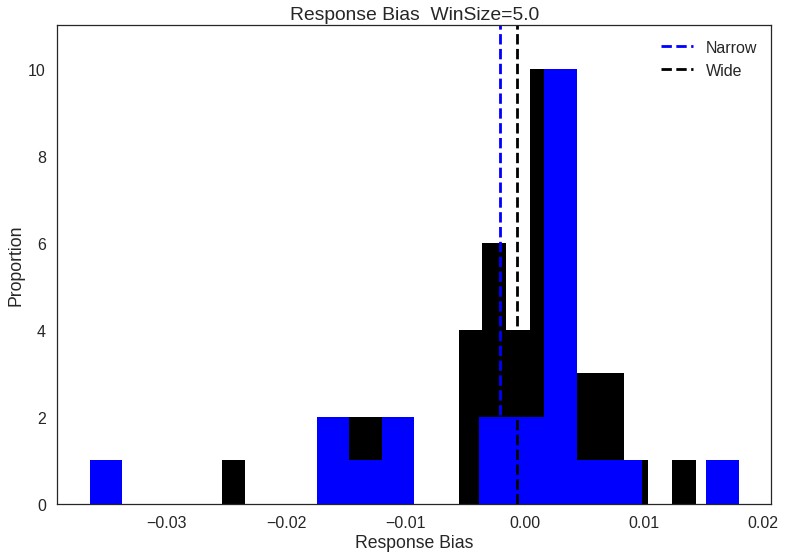

In [30]:
nbins = 20
wide_finite = wide_mse_diff[~np.logical_or(np.isnan(wide_mse_diff), np.isinf(wide_mse_diff))]
narrow_finite = narrow_mse_diff[~np.logical_or(np.isnan(narrow_mse_diff), np.isinf(narrow_mse_diff))]
(n1, bin1, p1) = plt.hist(wide_mse_diff[~np.logical_or(np.isnan(wide_mse_diff), np.isinf(wide_mse_diff))], nbins, facecolor='k', normed=False)
(n2, bin2, p2) = plt.hist(narrow_mse_diff[~np.logical_or(np.isnan(narrow_mse_diff), np.isinf(narrow_mse_diff))], nbins, facecolor='b', normed=False)
narrow_mean = np.mean(narrow_mse_diff[~np.logical_or(np.isnan(narrow_mse_diff), np.isinf(narrow_mse_diff))])
wide_mean = np.mean(wide_mse_diff[~np.logical_or(np.isnan(wide_mse_diff), np.isinf(wide_mse_diff))])
plt.plot([narrow_mean, narrow_mean], [0, 200], 'b--')
plt.plot([wide_mean, wide_mean], [0, 200], 'k--')
plt.ylim([0, np.amax(np.stack([n1, n2], axis=-1))+1])
plt.title('Response Bias  WinSize={}'.format(winsize))
plt.xlabel('Response Bias')
plt.ylabel('Proportion')
plt.legend(['Narrow', 'Wide'])
plt.savefig(os.path.join(block_path, 'ResponseBiasHistogram_{}.png'.format(winsize)))

print(narrow_mean)
print(wide_mean)

from scipy.stats import mannwhitneyu
(U, p) = mannwhitneyu(wide_finite, narrow_finite, alternative='two-sided')
print(p)

## Response Bias Histogram over Significantly Attention-Modulated Cells

-0.00421043777657
-0.00112256622343
0.789550874742


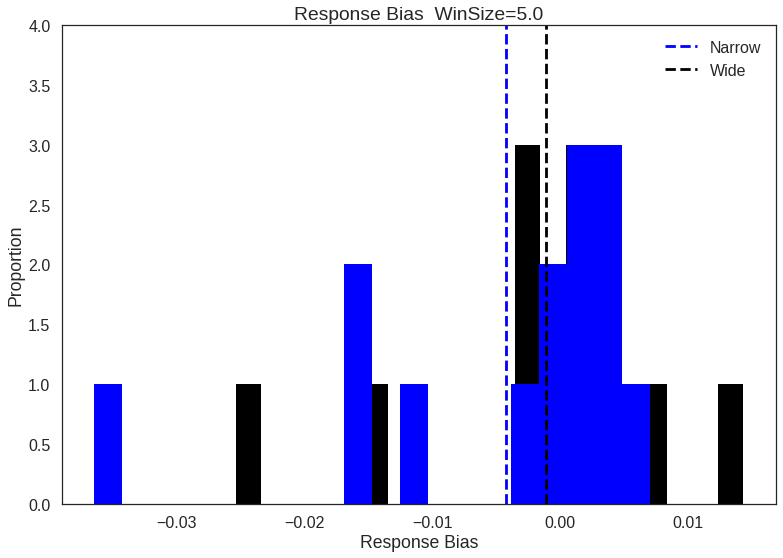

In [31]:
nbins = 20
wide_attn_finite = wide_attn_mse_diff[~np.logical_or(np.isnan(wide_attn_mse_diff), np.isinf(wide_attn_mse_diff))]
narrow_attn_finite = narrow_attn_mse_diff[~np.logical_or(np.isnan(narrow_attn_mse_diff), np.isinf(narrow_attn_mse_diff))]
(n1, bin1, p1) = plt.hist(wide_attn_finite, nbins, facecolor='k', normed=False)
(n2, bin2, p2) = plt.hist(narrow_attn_finite, nbins, facecolor='b', normed=False)
narrow_mean = np.mean(narrow_attn_finite)
wide_mean = np.mean(wide_attn_finite)
plt.plot([narrow_mean, narrow_mean], [0, 200], 'b--')
plt.plot([wide_mean, wide_mean], [0, 200], 'k--')
plt.ylim([0, np.amax(np.stack([n1, n2], axis=-1))+1])
plt.title('Response Bias  WinSize={}'.format(winsize))
plt.xlabel('Response Bias')
plt.ylabel('Proportion')
plt.legend(['Narrow', 'Wide'])
plt.savefig(os.path.join(block_path, 'ResponseBiasHistogram_AttnUnits_{}.png'.format(winsize)))

print(narrow_mean)
print(wide_mean)
from scipy.stats import mannwhitneyu
(U, p) = mannwhitneyu(wide_attn_finite, narrow_attn_finite, alternative='two-sided')
print(p)

In [ ]:
# compute max firing rate from each cell

psths = np.stack([avg_psths[x] for x in avg_psths.keys()], axis=-1)
maxfr = np.amax(psths, axis=(1,2))

In [ ]:
# Stimulus Response Error

SRE_C_hi = np.mean(np.square(avg_psths['AS_hi'] - avg_psths['A_hi']), axis=1)
SRE_C_lo = np.mean(np.square(avg_psths['AS_lo'] - avg_psths['A_lo']), axis=1)
SRE_X_hi = np.mean(np.square(avg_psths['ASX_hi'] - avg_psths['AX_hi']), axis=1)
SRE_X_lo = np.mean(np.square(avg_psths['ASX_lo'] - avg_psths['AX_lo']), axis=1)
SRE_C = np.mean(np.stack([SRE_C_hi, SRE_C_lo], axis=-1), axis=1)
SRE_X = np.mean(np.stack([SRE_X_hi, SRE_X_lo], axis=-1), axis=1)

SRE_C_norm = np.divide(SRE_C, maxfr)
SRE_X_norm = np.divide(SRE_X, maxfr)
plt.plot(SRE_C_norm, SRE_X_norm, 'k.')
plt.plot(np.arange(np.amax(SRE_C_norm)), np.arange(np.amax(SRE_C_norm)), 'k--')
plt.xlabel('Correct Trial SRE')
plt.ylabel('Incorrect Trial SRE')
plt.title('SRE   Winsize: {}'.format(winsize))
plt.savefig(os.path.join(block_path, 'StimulusResponseErrorScatter_{}.png'.format(winsize)))


In [ ]:
mean_SRE_C = np.mean(SRE_C_norm)
mean_SRE_X = np.mean(SRE_X_norm)
index = np.arange(2)/2
bar_width = 0.15
std_C = np.std(SRE_C_norm) / np.sqrt(len(SRE_C_norm))
std_X = np.std(SRE_X_norm) / np.sqrt(len(SRE_X_norm))

plt.figure()
plt.bar(index, [mean_SRE_C, mean_SRE_X], bar_width, yerr=(std_C, std_X))
plt.xlabel('Trial')
plt.ylabel('Stimulus Response Error')
plt.title('Stimulus Response Error')
plt.xticks(index, ('C', 'X'))
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(block_path, 'SREBar_{}.png'.format(winsize)))


In [ ]:
def subtract_mean(arr, axis):
    
    shp = arr.shape
    means = np.mean(arr, axis=axis)
    meanmat = np.tile(means[:, np.newaxis], (1, shp[1]))
    return np.subtract(arr,meanmat)

# PSTH Correlation

P_hi = subtract_mean(avg_psths['P_hi'], 1)
P_lo = subtract_mean(avg_psths['P_lo'], 1)
A_hi = subtract_mean(avg_psths['A_hi'], 1)
A_lo = subtract_mean(avg_psths['A_lo'], 1)

P = np.diag(np.dot(P_hi, P_lo.T))
P_norm = np.sqrt(np.multiply(np.diag(np.dot(P_hi, P_hi.T)), np.diag(np.dot(P_lo, P_lo.T))))
P_corr = np.divide(P, P_norm)

A = np.diag(np.dot(A_hi, A_lo.T))
A_norm = np.sqrt(np.multiply(np.diag(np.dot(A_hi, A_hi.T)), np.diag(np.dot(A_lo, A_lo.T))))
A_corr = np.divide(A, A_norm)

plt.figure(figsize=(7,7))
plt.plot(P_corr, A_corr, 'k.')
plt.plot(np.arange(-0.1, 1), np.arange(-0.1, 1), 'k--')
plt.xlim([-0.05, 0.5])
plt.ylim([-0.05, 0.5])
plt.xlabel('r passive')
plt.ylabel('r correct attention')
plt.title('Correlation   Winsize: {}'.format(winsize))
plt.savefig(os.path.join(block_path, 'PSTHCorrelationScatter_{}.png'.format(winsize)))


In [ ]:
a_h = np.random.standard_normal((20, 100))
as_h = np.random.standard_normal((20, 100))
a_l = np.random.standard_normal((20, 100))
as_l = np.random.standard_normal((20, 100))

mse_t = mse(a_h, as_h, a_l, as_l)
mse_d = mse(a_h, as_l, a_l, as_h)
mse_diff = mse_d - mse_t

In [ ]:
# compute significantly modulated bins:

filt_poptens = {}
for context in contexts:
    with h5.File(context_bdf[context], 'r') as binned_data:
        stim = context_stimuli[context]
        fulldata = np.array(binned_data[stim]['pop_tens'])
        filt_data = np.zeros(np.shape(fulldata))
        for cell in range(fulldata.shape[0]):
            for trial in range(fulldata.shape[2]):
                filt_data[cell, :, trial] = exp_filt(fulldata[cell, :, trial], 8.0)
                
        filt_poptens[str(context)] = filt_data
        binned_clusters = np.array(binned_data[stim]['clusters'])
        
dprimes = (np.mean(filt_poptens['A_hi'], axis=2) - np.mean(filt_poptens['A_lo'], axis=2))
dprimes = np.divide(dprimes, np.sqrt(np.var(filt_poptens['A_hi'], axis=2) + np.var(filt_poptens['A_lo'], axis=2) / 2 ))
